In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [2]:
%%time
common_test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                          511, 516, 1838, 1896]

additional_test_station_id = []

test_station_id = common_test_station_id + additional_test_station_id


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228,
                    239, 305, 308, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis, interpol_freq=20)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_dampness', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY], data[MmxColumns.ID_ROAD_TEMPERATURE]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 39s, sys: 11.8 s, total: 1min 51s
Wall time: 1min 51s


## Feature selection

In [3]:
from preprocessing import create_feature_df
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from functools import partial

In [4]:
point = pd.Timestamp(2015, 6, 1)

target = 'data_dampness'

params_df = {}
params_df['target'] = target
params_df['variables'] = ['data_t_air', 'data_t_road', 'data_t_underroad', 
                          'data_pressure', 'data_dampness']
params_df['interpol_freq'] = 20
params_df['lag_list'] = (1, 2, 3, 4, 5, 6, 7, 8)
params_df['diff_list'] = ((1, 2), (2, 3), (3, 4), (4, 5), (5, 6))
params_df['coordinates'] = True
params_df['solar_angles'] = True
params_df['road_id'] = False
params_df['day_of_year'] = True
params_df['month'] = False
params_df['hour'] = True
params_df['post_process'] = False

min_value = 0
max_value = 100
train_filtered = copy(train[(train[target] < max_value) & (train[target] > min_value)])
df_train = create_feature_df(train_filtered[train_filtered['date_time_utc'] < point], **params_df)
df_valid = create_feature_df(train_filtered[train_filtered['date_time_utc'] >= point], **params_df)
df_test = create_feature_df(test, **params_df)

In [5]:
main_cols = ('data_t_road', 'data_t_air', 'data_t_underroad', 'data_pressure', 'data_humidity')
features = [col for col in df_train if col.startswith('data_')]
#features = [col for col in features if col not in (main_cols)]
target = [col for col in df_train if col.startswith('target_')][0]

X_train = np.array(df_train[features].values)
y_train = np.array(df_train[target].values)

X_valid = np.array(df_valid[features].values)
y_valid = np.array(df_valid[target].values)

X_test = np.array(df_test[features].values)
y_test = np.array(df_test[target].values)

lgb_train = lgb.Dataset(X_train, y_train, feature_name=features)
lgb_val = lgb.Dataset(X_valid, y_valid, reference=lgb_train, feature_name=features)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, feature_name=features)

## Train model

In [6]:
df = df_valid
baseline_mae = mean_absolute_error(df.data_dampness_lag_20, df.target_dampness)
baseline_mse = mean_squared_error(df.data_dampness_lag_20, df.target_dampness)

print('MAE: {0: .3f} \nMSE: {1: .3f}'.format(baseline_mae, baseline_mse))

MAE:  0.941 
MSE:  2.562


In [7]:
#	 train's l1: 0.555803	valid's l1: 0.565591	test's l1: 0.569813

In [8]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l1',
    'num_leaves': 40,
    'learning_rate': 0.1,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=(lgb_train, lgb_val, lgb_test),
                valid_names=('train', 'valid', 'test'),
                verbose_eval=200,)

[200]	train's l1: 0.692769	valid's l1: 0.596166	test's l1: 0.616999
[400]	train's l1: 0.6494	valid's l1: 0.571212	test's l1: 0.572938
[600]	train's l1: 0.623694	valid's l1: 0.557452	test's l1: 0.550272
[800]	train's l1: 0.602623	valid's l1: 0.545885	test's l1: 0.533644
[1000]	train's l1: 0.587791	valid's l1: 0.538543	test's l1: 0.520914
[1200]	train's l1: 0.574104	valid's l1: 0.531841	test's l1: 0.510987
[1400]	train's l1: 0.561989	valid's l1: 0.525823	test's l1: 0.503874
[1600]	train's l1: 0.552386	valid's l1: 0.521974	test's l1: 0.497114
[1800]	train's l1: 0.542873	valid's l1: 0.51795	test's l1: 0.493131
[2000]	train's l1: 0.534683	valid's l1: 0.514503	test's l1: 0.48904
[2200]	train's l1: 0.527034	valid's l1: 0.511657	test's l1: 0.485035
[2400]	train's l1: 0.52022	valid's l1: 0.509138	test's l1: 0.488542
[2600]	train's l1: 0.513808	valid's l1: 0.507044	test's l1: 0.488098
[2800]	train's l1: 0.507568	valid's l1: 0.504918	test's l1: 0.501268
[3000]	train's l1: 0.501954	valid's l1: 0.5

In [10]:
z = list(zip(features, list(gbm.feature_importance())))
z.sort(key=lambda item: item[1], reverse=True)
z[:10]

[('data_t_air', 8247),
 ('data_dampness_diff_20_40', 6155),
 ('data_t_air_diff_20_40', 5686),
 ('data_t_air_lag_20', 5466),
 ('data_dampness_diff_40_60', 5312),
 ('data_dampness_lag_20', 4943),
 ('data_dampness_diff_60_80', 4467),
 ('data_t_underroad_diff_20_40', 4075),
 ('data_t_road_diff_20_40', 3899),
 ('data_dampness_lag_40', 3860)]

## Save Model

import pickle

f = open('/mnt/HARD/MinMax94/models/anomaly_detection/detector_humidity.pickle','wb')                                                                                                                                                                                                                                                           
pickle.dump(gbm,f)                                                                                                                                                                                                                                                                        
f.close()

## Predict values

In [10]:
y_pred = gbm.predict(X_test)
y_train_pred = gbm.predict(X_train)

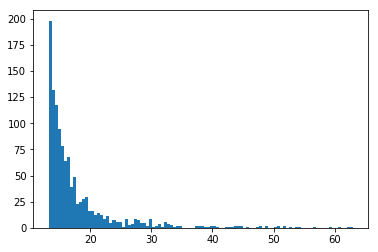

In [22]:
import matplotlib.pyplot as plt

hist = np.abs(df_train.target_dampness - df_train.data_dampness_lag_20).nlargest(len(df_train) // 1000)
plt.hist(hist, bins=100, )
plt.show()

## Decision Function

In [36]:
threshold = 13
df_train['predict_pressure'] = y_train_pred
df_train['label_predict'] = np.abs(y_train - y_train_pred) > threshold
num_of_outliers = len(df_train[df_train['label_predict']])
percentage = num_of_outliers / len(df_train)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_train)))

Ratio of anomalies is 0.00004% (49 out of 1175823)


In [37]:
df_train.groupby('station_id')['label_predict'].sum()

station_id
113      1.0
115      0.0
116      1.0
118      0.0
126      0.0
150      3.0
152      1.0
200      0.0
223      2.0
228      3.0
239      1.0
305      0.0
308      1.0
401      0.0
411      4.0
432      2.0
435      5.0
454      5.0
456      4.0
593      0.0
628      2.0
1831     0.0
1899     0.0
1911     1.0
1921     2.0
4007     2.0
20323    0.0
20717    1.0
20743    3.0
20754    1.0
20755    0.0
20761    0.0
20916    2.0
20921    2.0
Name: label_predict, dtype: float64

In [74]:
threshold = 13
df_test['predict_dampness'] = y_pred
df_test['label_predict'] = np.abs(y_test - y_pred) > threshold
num_of_outliers = len(df_test[df_test['label_predict']])
percentage = num_of_outliers / len(df_test)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_test)))

Ratio of anomalies is 0.00007% (68 out of 935583)


In [75]:
df_test.groupby('station_id')['label_predict'].sum()

station_id
114      6.0
117      0.0
119      3.0
302      2.0
303      0.0
307      6.0
393      6.0
442      7.0
503      3.0
504      4.0
511      4.0
516     14.0
1838     5.0
1896     8.0
Name: label_predict, dtype: float64

## Plot result

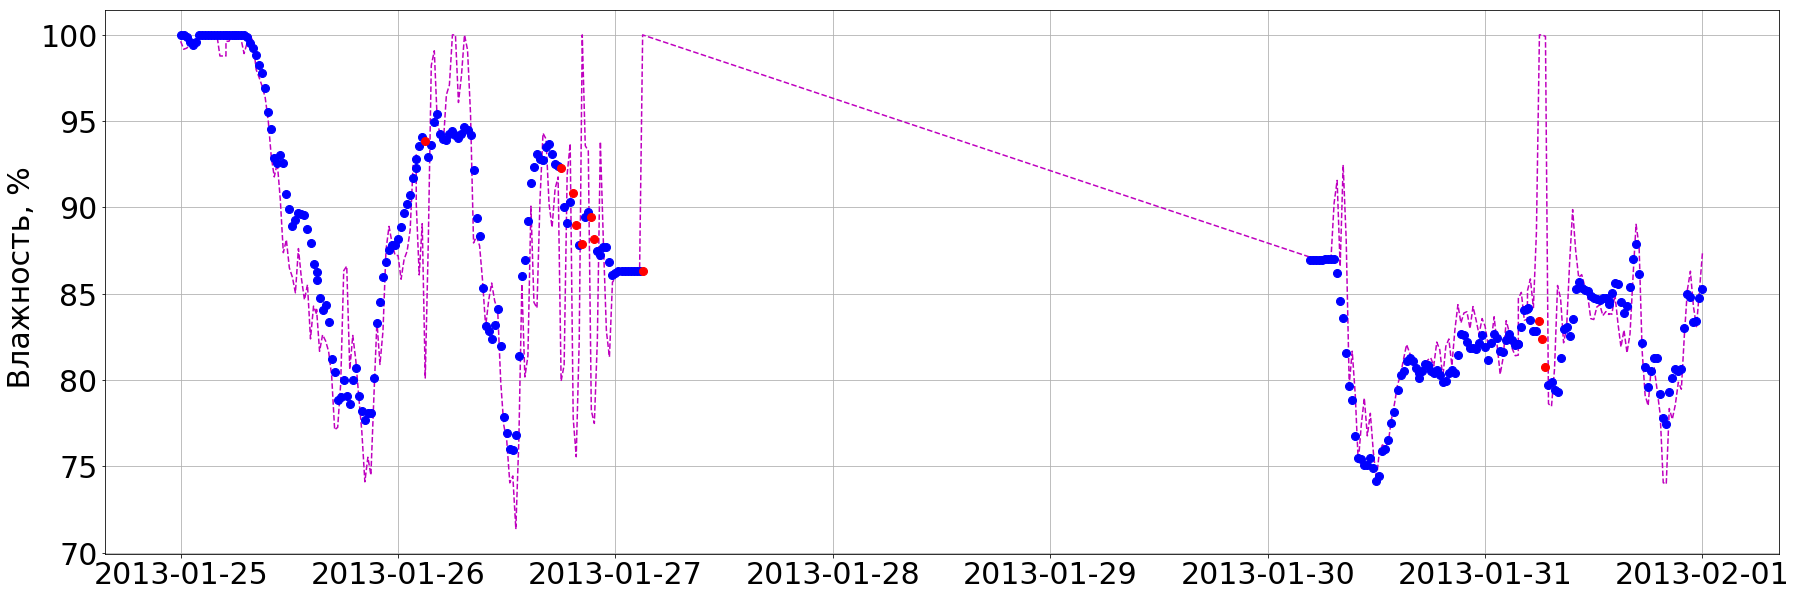

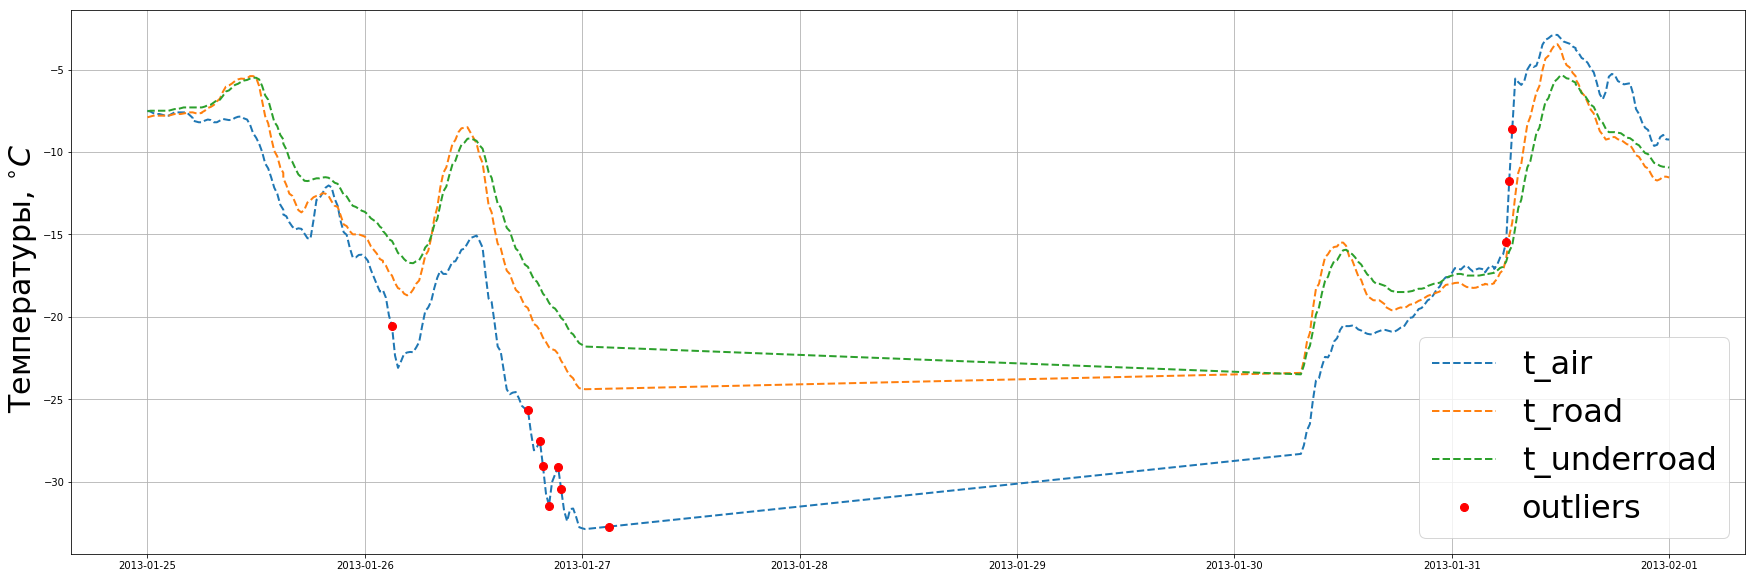

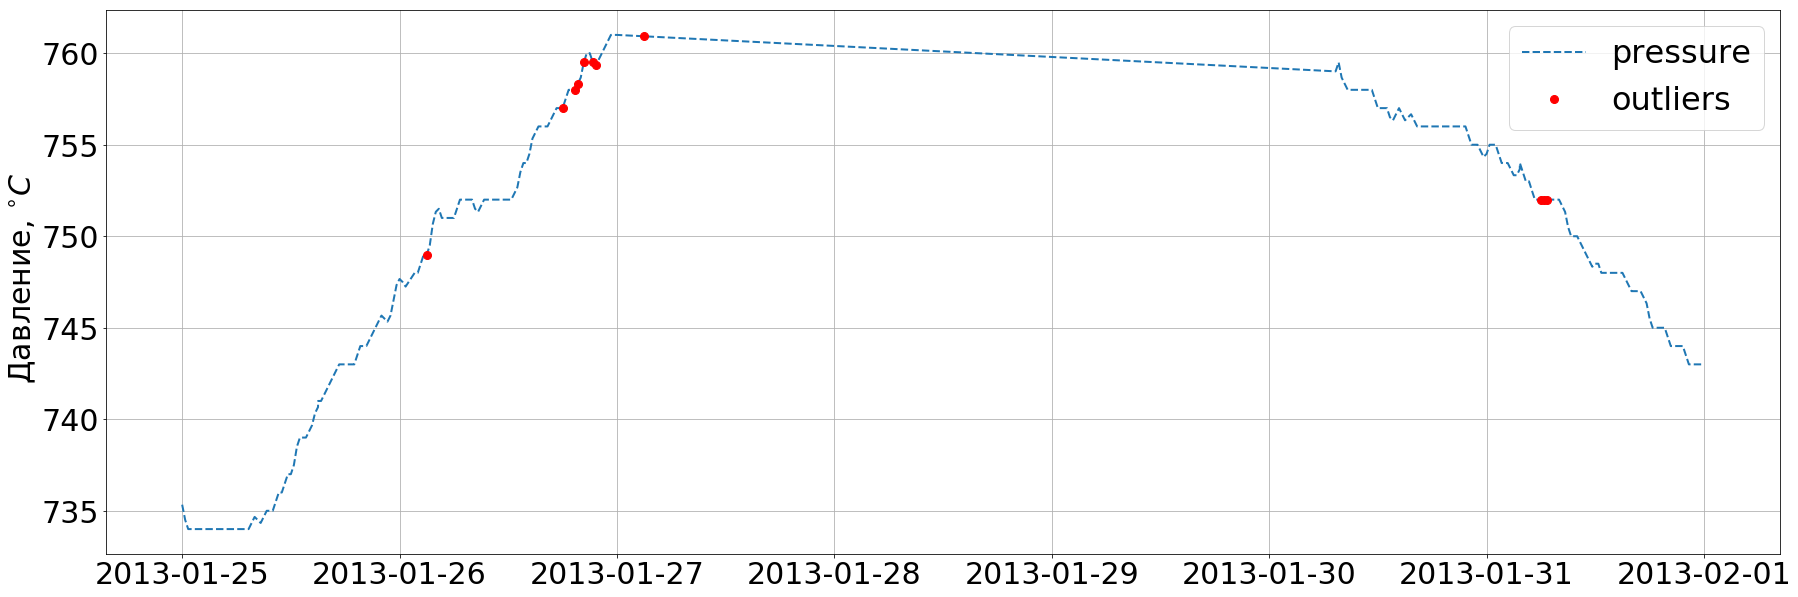

In [125]:
import matplotlib.pyplot as plt

#####-----------------------------STATION_ID-------------------------------#####
z = copy(df_test[df_test['station_id']==119].set_index('date_time_utc'))
#z = copy(df_train[df_train['station_id']==1838].set_index('date_time_utc'))

#####-----------------------------TIME_INTERVAL-------------------------------#####
start = pd.Timestamp(2013, 1, 25)
end = pd.Timestamp(2013, 2, 1)
to_plot = z[(z.index<=end) & (z.index>=start)]


#####-----------------------------PRESSURE-------------------------------#####
plt.figure(figsize=(30, 10))

plt.plot_date(to_plot.index, to_plot['predict_dampness'], 'm',
                      linestyle='--', marker='None', markersize=8, label='predicted dampness')

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_dampness'], 'b',
                      linestyle='none', marker='o', markersize=8, label='true dampness')
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_dampness'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
#plt.legend(fontsize=32)
#plt.ylim((720, 780))
plt.ylabel(r' Влажность, %', fontsize=30)

plt.tick_params(labelsize=30)


#####-----------------------------TEMPERATURE-------------------------------#####
plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot.index, to_plot['data_t_air'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_air')
        
        plt.plot_date(to_plot.index, to_plot['data_t_road'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_road')
        
        plt.plot_date(to_plot.index, to_plot['data_t_underroad'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_underroad')
        
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['data_t_air'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температуры, $^{\circ}C$', fontsize=30)

#####-----------------------------HUMIDITY-------------------------------#####
plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot.index, to_plot['data_pressure'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='pressure')
        
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['data_pressure'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Давление, $^{\circ}C$', fontsize=30)


plt.tick_params(labelsize=30)

plt.show()